# Demo - Entity Matching with an LLM

* Replicate results for benchmark on [Entity Resolution(https://paperswithcode.com/sota/entity-resolution-on-abt-buy)

### Sources:
* https://paperswithcode.com/paper/entity-matching-using-large-language-models
* https://paperswithcode.com/sota/entity-resolution-on-abt-buy

### Requirements

In [1]:
!pip install pypdf langchain openai langchain-openai neo4j python-dotenv langchainhub langchain-community --quiet

In [2]:
%load_ext watermark
%watermark -p langchain,langchainhub,langchain_community,pypdf

langchain          : 0.1.5
langchainhub       : 0.1.14
langchain_community: 0.0.17
pypdf              : 4.0.1



### Imports

In [3]:
import os
from graphdatascience import GraphDataScience
from dotenv import load_dotenv, find_dotenv, dotenv_values
from pathlib import Path
import neo4j
import json

from langchain_openai import ChatOpenAI

from langchain.agents import AgentExecutor, create_react_agent
from langchain.chains import LLMChain
from langchain.chains.conversation.memory import ConversationBufferMemory
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.output_parsers.json import SimpleJsonOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools import Tool

from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain

from langchain import hub
from langchain_openai import OpenAIEmbeddings

import pandas as pd
import pickle
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score
from sklearn.metrics import PrecisionRecallDisplay

### Settings

In [5]:
project_path = Path(os.getcwd()).parent
data_path = project_path / "data"
model_path = project_path / "models"
output_path = project_path / "output"

llm_model = "gpt-4"

# load env settings
load_dotenv("../.env.lotr")

openai_api_key = os.getenv('OPENAI_API_KEY')

np.random.seed(42)

### Helper functions

In [6]:
def evaluate(emb1, emb2, df):
    similarity = cosine_similarity(embeddings_abt, embeddings_buy)

    output = []
    for i in np.arange(len(similarity)):
        output.append(similarity[i][i])
    df_train['similarity'] = output

        # matches
    idx_1 = df_train_merged[df_train_merged.matching == True].index.tolist()
    df_train_match = df_train.loc[idx_1, :]

    # no matches
    idx_0 = df_train_merged[df_train_merged.matching == False].index.tolist()
    df_train_no_match = df_train.loc[idx_0, :]
    
    plt.boxplot([df_train_match['similarity'], df_train_no_match['similarity']], labels=["match", "no match"])
    plt.show()

    # train decision tree
    X = df_train['similarity'].values.reshape(-1, 1)
    y = df_train[['matching']]*1

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

    # fit model
    clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
    clf_model.fit(X_train,y_train)
    y_pred = clf_model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['no match', 'match']))
    print("f1 score: ", f1_score(y_test, y_pred))
    
    # precision recall curve
    display = PrecisionRecallDisplay.from_estimator(
        clf_model, X_test, y_test, name="LinearSVC", plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

### 1. Load Data

In [7]:
os.listdir(data_path / 'abt-buy' / 'record_descriptions')

['2_buy.csv', '1_abt.csv']

In [8]:
df_train = pd.read_csv(data_path / 'abt-buy' / 'gs_train.csv')
df_abt = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '1_abt.csv', encoding='unicode_escape')
df_buy = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '2_buy.csv')
display(df_train.head())
display(df_abt.head())
display(df_buy.head())

,source_id,target_id,matching
0,33161,207390654,False
1,36258,208085180,False
2,17417,90125786,False
3,34309,208504304,False
4,8060,90138537,False


,subject_id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399.0
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49.0
3,5644,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,NaN
4,6284,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158.0


,subject_id,name,description,manufacturer,price
0,10011646,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,LINKSYS,NaN
1,10140760,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,LINKSYS,NaN
2,10221960,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,Netgear,NaN
3,10246269,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,Belkin,NaN
4,10315184,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,Netgear,NaN


In [9]:
df_abt_merged = df_abt.merge(df_train, left_on='subject_id', right_on='source_id', how='right')
df_train_merged = df_buy.merge(df_abt_merged, left_on='subject_id', right_on='target_id', how='right')

In [10]:
df_train_merged.head()

,subject_id_x,name_x,description_x,manufacturer,price_x,subject_id_y,name_y,description_y,price_y,source_id,target_id,matching
0,207390654,Sony Handycam HDR-SR10 High Definition Digital...,16:9 - 2.7' Hybrid LCD,Sony,549.00,33161,Sony High Definition HDV Handycam Camcorder - ...,Sony High Definition HDV Handycam Camcorder - ...,NaN,33161,207390654,False
1,208085180,Pioneer DEH-2000MP Car Audio Player,"CD-RW - CD-Text, MP3, WMA, WAV - LCD - 4 - 200...",Pioneer,84.00,36258,D-Link Broadband Cable Modem - DCM202,D-Link Broadband Cable Modem - DCM202/ DOCSIS ...,79.00,36258,208085180,False
2,90125786,Sanus Wall/Ceiling Speaker Mount - WMS3S SILVER,Plastic - 8 lb,Sanus,NaN,17417,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,39.99,17417,90125786,False
3,208504304,Sony HT7200DH Home Theater System,"DVD Player, A/V Receiver, 5.1 Speakers - 1 Dis...",Sony,376.96,34309,Sony Bravia Wireless Home Theater System In Bl...,Sony Bravia Wireless Home Theater System In Bl...,NaN,34309,208504304,False
4,90138537,Panasonic KX-TSC14B Corded Telephone,2 x Phone Line(s) - Headset - Black,Panasonic,NaN,8060,Panasonic 2-Line Integrated Telephone System -...,Panasonic 2-Line Integrated Telephone System -...,NaN,8060,90138537,False


### Generate embeddings for name attribute

In [11]:
%%time
# Wall time: 25.5 s
embeddings_model = OpenAIEmbeddings()

CPU times: user 9.04 ms, sys: 1.83 ms, total: 10.9 ms
Wall time: 10.9 ms


#### Name embeddings

In [12]:
names_abt = df_train_merged.name_x.tolist()
names_buy = df_train_merged.name_y.tolist()

In [13]:
%%time 
# ~ 25seconds

generate_name_embeddings = False

if generate_name_embeddings == True:
    embeddings_abt = embeddings_model.embed_documents(names_abt)
    embeddings_buy = embeddings_model.embed_documents(names_buy)

    # save to pickle
    file = open(data_path / 'embeddings_abt_name_train.pickle', 'wb')
    pickle.dump(embeddings_abt, file)
    file.close()
    
    file = open(data_path / 'embeddings_buy_name_train.pickle', 'wb')
    pickle.dump(embeddings_buy, file)
    file.close()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


#### Read embeddings from file

In [14]:
embeddings_abt = pickle.load(open(data_path / 'embeddings_abt_name_train.pickle', 'rb'))
embeddings_buy = pickle.load(open(data_path / 'embeddings_buy_name_train.pickle', 'rb'))

#### Evaluate

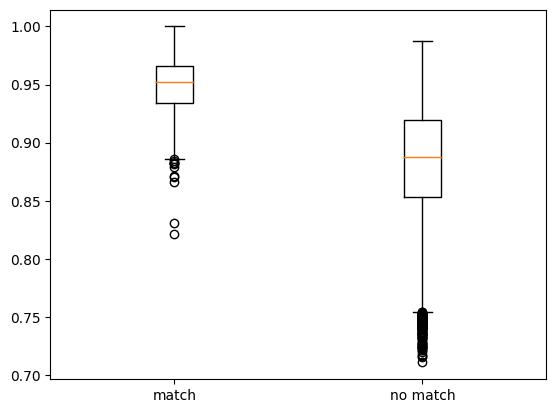

              precision    recall  f1-score   support

    no match       0.89      0.98      0.93      1263
       match       0.77      0.39      0.52       240

    accuracy                           0.88      1503
   macro avg       0.83      0.68      0.73      1503
weighted avg       0.87      0.88      0.87      1503

f1 score:  0.5193370165745856


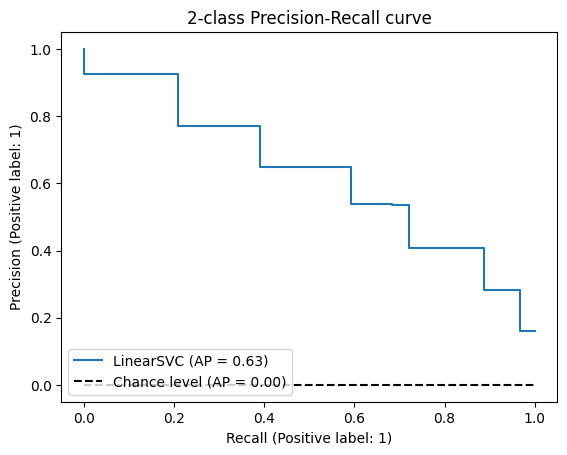

In [15]:
evaluate(embeddings_abt, embeddings_buy, df_train)

### Description embeddings

In [16]:
descriptions_abt = [str(s) for s in df_train_merged.description_x.tolist()]
descriptions_buy = [str(s) for s in df_train_merged.description_y.tolist()]

In [17]:
%%time
# Wall time: 32.4 s
generate_description_embeddings = False

if generate_description_embeddings == True:
    embeddings_abt = embeddings_model.embed_documents(descriptions_abt)
    print("abt embeddings done")
    embeddings_buy = embeddings_model.embed_documents(descriptions_buy)
    print("buy embeddings done")
    
    # save to pickle
    file = open(data_path / 'embeddings_abt_description_train.pickle', 'wb')
    pickle.dump(embeddings_abt, file)
    file.close()
    
    file = open(data_path / 'embeddings_buy_description_train.pickle', 'wb')
    pickle.dump(embeddings_buy, file)
    file.close()

CPU times: user 5 µs, sys: 10 µs, total: 15 µs
Wall time: 4.05 µs


#### Read embeddings from file

In [18]:
embeddings_abt = pickle.load(open(data_path / 'embeddings_abt_description_train.pickle', 'rb'))
embeddings_buy = pickle.load(open(data_path / 'embeddings_buy_description_train.pickle', 'rb'))

#### Evaluate

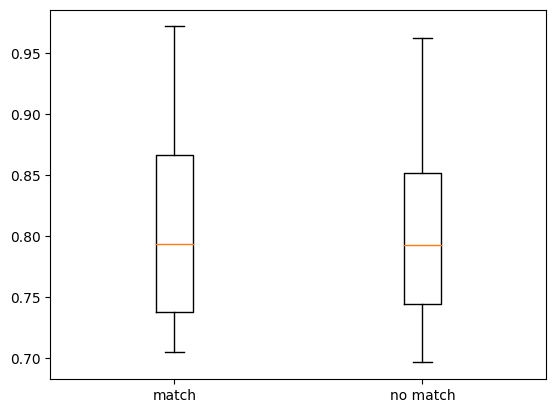

              precision    recall  f1-score   support

    no match       0.85      0.99      0.92      1263
       match       0.74      0.10      0.17       240

    accuracy                           0.85      1503
   macro avg       0.80      0.54      0.54      1503
weighted avg       0.83      0.85      0.80      1503

f1 score:  0.16974169741697417


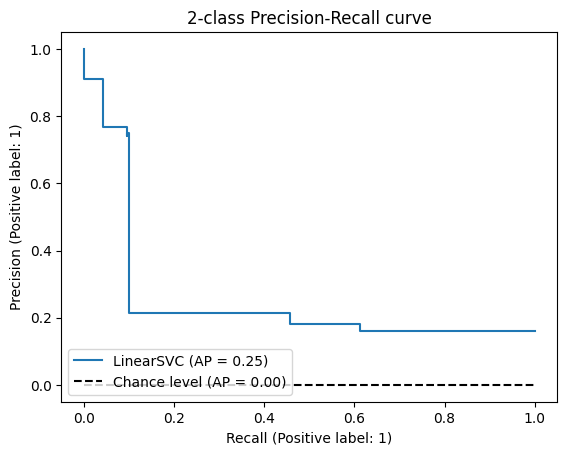

In [19]:
evaluate(embeddings_abt, embeddings_buy, df_train)

### Name + Description embeddings

In [20]:
descriptions_name_abt = [f"{names_abt[i]}-{description}" for i, description in enumerate(descriptions_abt)]
descriptions_name_buy = [f"{names_buy[i]}-{description}" for i, description in enumerate(descriptions_buy)]

In [21]:
%%time
# Wall time: 39.5 s
generate_name_description_embeddings = False

if generate_name_description_embeddings == True:
    embeddings_abt = embeddings_model.embed_documents(descriptions_name_abt)
    print("abt embeddings done")
    embeddings_buy = embeddings_model.embed_documents(descriptions_name_buy)
    print("buy embeddings done")
    
    # save to pickle
    file = open(data_path / 'embeddings_abt_name_description_train.pickle', 'wb')
    pickle.dump(embeddings_abt, file)
    file.close()
    
    file = open(data_path / 'embeddings_buy_name_description_train.pickle', 'wb')
    pickle.dump(embeddings_buy, file)
    file.close()

CPU times: user 5 µs, sys: 23 µs, total: 28 µs
Wall time: 9.3 µs


#### Read embeddings from file

In [22]:
embeddings_abt = pickle.load(open(data_path / 'embeddings_abt_name_description_train.pickle', 'rb'))
embeddings_buy = pickle.load(open(data_path / 'embeddings_buy_name_description_train.pickle', 'rb'))

#### Evaluate

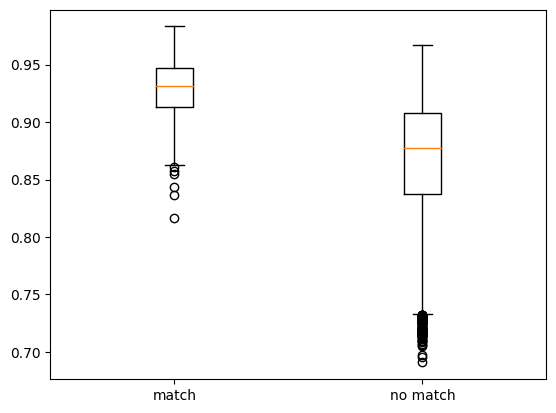

              precision    recall  f1-score   support

    no match       0.87      0.98      0.92      1263
       match       0.74      0.23      0.35       240

    accuracy                           0.86      1503
   macro avg       0.80      0.60      0.63      1503
weighted avg       0.85      0.86      0.83      1503

f1 score:  0.3450479233226837


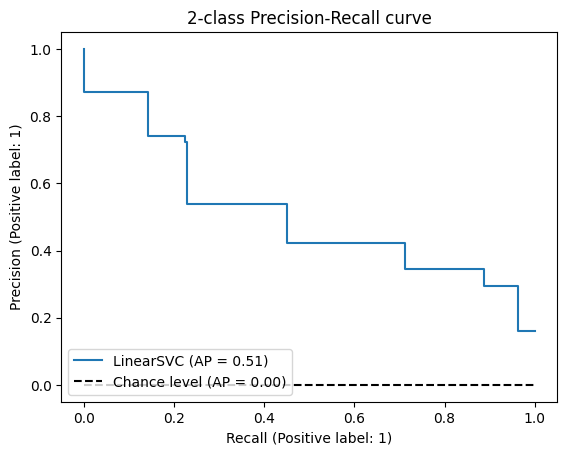

In [23]:
evaluate(embeddings_abt, embeddings_buy, df_train)

### Results

#### Populations: matches/no-matches

* f1-score for OpenAI embeddings on `name`: 0.5193370165745856
* f1-score for OpenAI embeddings on `description`: 0.16974169741697417 (!)
* f1-score for OpenAI embeddings on `name` and `description`: 0.3450479233226837